# 1. Implementing your own Shazam

In [1]:
import pandas as pd
import numpy as np      
import matplotlib.pyplot as plt 
import scipy.io.wavfile 
import subprocess
import librosa
import librosa.display
import IPython.display as ipd
from IPython.core.display import HTML
import pickle

from collections import Counter
from sklearn.cluster import KMeans
import seaborn as sns

from pathlib import Path, PurePath   
from tqdm.notebook import tqdm

In [2]:
from AudioSignals import *
from LSH_functions import *
from clustering import *

# 1. Implementing your own Shazam

## 1.1 Getting your data!
We downloaded the dataset from kaggle and inserted the audio processing functions from [AudioSignals.ipynb](https://github.com/lucamaiano/ADM/blob/master/2021/Homework_4/AudioSignals.ipynb) into the library AudioSignals.py.

We then converted every downloaded track from mp3 to wav:

In [138]:
track_conversion()

## 1.2. Grouping songs together!

We decided to consult different book, articles and documentation and to mix up different ideas to implement our code: the principal source of ispiration was this [book](http://infolab.stanford.edu/~ullman/mmds/ch3n.pdf).

We established the following pipeline:

0. We preprocessed every song by extracting a "signature" that identifies each song;

1. We created a dictionary of songs and a dictionary of shingles (to be able to work with integers only).

2. We implemented some functions to retrieve these.

3. We implement the same logic of step 1 to produce a json file of shingles encoded by integers.

4. We create our dataset which is initially a (#different shingles, #songs) size matrix and we filled it with 1 if the shingles is present in that song.

5. This is a very sparse matrix and it is inefficient to work with, so, following the idea of minhashing, we create a family of hash functions to implement a signature matrix.

6. We now create the signature matrix.

7. We defined functions to compute the Jaccard similarity between the query and the columns of the signature matrix.

8. Finally, we implemented the final bit of the LSH algorithm and we wrote the final search utility.

This structure allowed us to divide the work and to work in parallel on different tasks

### Part 0: preprocessing

We create a txt file containing the paths of all the songs. The enumeration of the lines in this file is used as a dictionary to associate every song to an integer.

In [139]:
create_wav_list()

We preprocessed every song by extracting a "signature" that identifies each song in the following way (using librosa):
* perform onset detection for every song; the onset detection is a way to characterize a series of musical events constituting the basic rhythmic content of the audio (from [here](https://sci-hub.se/10.1109/ICASSP.2015.7178003))
* find the peak in strenght for the onset detection function;
* compute the Fourier transform of the input track to have a frequency decomposition of the signal at each time;
* find the most intense (in amplitude) frequency at each peak time (according to the onset envelope) using the frequency decomposition in the previous point
* create for every song a set of triplets containing the frequency associated to two consecutive peaks, and the (time) distance between these two peaks; this triplets should provide a good summary of the actual song and will be used as the shingles (words) in our documents (the songs);

It is useful to note that, in order to compute the Discrete Fourier Transform of every song, both time and frequency are binned. We could convert each of these binned values into actual frequencies and time values (and infact we wrote two functions to allow for this conversion) but, since the conversion factor is the same for every song, we preferred to work with our binned values. So every time that we talk about frequency and time, we are implicitly referring to this binned scale.

A spectrogram is a time-frequency representation of an audio signal laid out such that it shows the amplitude of each frequency at each point in time. Here we plot the spectrogram and a representation of the selected peaks of the onset dectection function for the $i^{th}$ song:

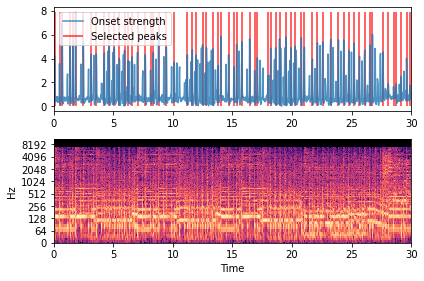

In [143]:
i = 0
indexed_plot_spectrogram_and_peaks(i)

Following the steps above, we now generate the triplets dictionary and the triplets set of every song and we saved everything leveraging Python's Pickle module.

In [144]:
generate_peak_triplets()

### Part 1-3: Save songs and shingles dictionary as json files

A shingle is a rappresentative feature of a track. As said above, after some attemps and some research, we concluded that the best rapresentation to capture the essential information about a song is given by the set of triplets ($ peak_{i}\ \ ,interval({i,i+1})\ \ ,peak_{i+1}  $).

Since pickle files can only be read using the pickle module itself, we also saved the dictionary of songs and triplets in json files to allow for quick editor consultation.

In [3]:
dictionary_songs_json()
shingle_dictionary_json()

### Part 4-7: creation of the signature matrix

We created a function to generate the parameters for several hash functions of the form   $ h(x) = (\alpha*x+ \beta )\mod{n} $   where $n$ is a prime number, and $ \alpha $ and $ \beta $ are integers smaller than $n$.

In [3]:
params_alpha, params_beta, n = hashfunction_family(3, 7)
print(params_alpha, params_beta, n)

[6 4 1] [2 1 0] 7


\begin{equation}
h_1(x) = 6x+2 \mod{7}
\end{equation}
\begin{equation}
h_2(x) = 4x+1 \mod{7}
\end{equation}
\begin{equation}
h_3(x) = x \mod{7}
\end{equation}

We create our dataset which is initially a  $\ \#shingles \times \#songs\ $  matrix and we fill it with 1 if the shingles is present in that song and zero otherwise. This is a very sparse matrix and it is inefficient to work with it, so it is entirely possible to generate the signature matrix without ever generate it; since our dataset is fairly small, we decided to use it anyway.
We then created the signature matrix, which is a new matrix that has a column for every song but just a handful of rows (we decided to start with 100 rows out of the $\approx$40000 row of the dataset matrix).

To create the signature matrix we implemented the following algorithm:

* Let $SIG(i, c)$ be the element of the signature matrix for the $i^{th}$ hash function and column c the song. 
* Initially, set $SIG(i, c)$ to $ \inf$  for all $i$ and $c$.
* For every row $r$ of the initial matrix do the following:
    * Compute $ h_{1}(r), h_{2}(r), \dots, h_{n}(r)$.
    * For each column $c$ do the following:
        (a) If $c$ has $0$ in row $r$, do nothing.
        (b) If $c$ has $1$ in row $r$, then for each $i = 1, 2, \dots , n$ set $SIG(i, c)$ to the smaller of the current value of $SIG(i, c)$ and $h_i(r)$.

The next cell concretely computes the signature matrix and saves it to the disk:

In [3]:
generate_signature_matrix()

The signature matrix has the following (fundamental) property: for each row $r$, and for any two columns $c_1,c_2$, the probability that $SIG(r, c_1)=SIG(r, c_2)$ is (approximately, since we are using hash functions instead of true permutations) equal to the Jaccard similarity of the sets associated with columns $c_1,c_2$.

Because of this last property, one can compute the Jaccard similarity of two documents as the relative frequency of identical rows for the signature matrix columns associated with the documents. The more the signature matrix columns, the more the computed similarity will be close to the real one.

### Part 8: LSH and search result finding

For the sake of the efficiency, we did not compute the Jaccard similarity between the query and every document, but instead we implemented another hashing technique:
* we added the query as a column to the signature matrix in $b$ bands of $r$ rows each, obtaining $b$ new matrices;
* we hashed every column of these $b$ matrices;
* we flagged as a similar pair every pair that hashed to the same number in the same band;
* we computed the similarity only between the similar pairs that contained the query column

One can prove that the probability that a document which has a Jaccard similarity $s$ (with the query) becomes a similar pair is about (since our hash functions can have collisions) $1-(1-s^r)^b$ (which is the probability that the signatures agree in all the rows of at least one band).

We define a threshold $t$ as the value
\begin{equation}
t = \left(1-\frac{1}{2^{\frac{1}{b}}}\right)^{\frac{1}{r}}
\end{equation}
which corresponds to the value of the Jaccard similarity at which the probability that the document becomes a similar pair with the query is $\frac{1}{2}$.

Finally, we start the search. Using the actual Shazam app (and our ears) we found the name of each query song:

In [3]:
# query contains the paths of every query song
query, query_names = query_results()
display(query_names)

,Song Name
Query 1,Dream_On
Query 2,I_Want_To_Break_Free
Query 3,October
Query 4,Ob-La-Di_Ob-La-Da
Query 5,Karma_Police
Query 6,Heartbreaker
Query 7,Go_Your_Own_Way
Query 8,American_Idiot
Query 9,Somebody
Query 10,Black_Friday


And we now use our algorithm to match these songs (the default threshold is about $0.9$, with 5 bands of 20 rows each).

In [4]:
search(query)

,Best Song Match
Query 1,Dream_On
Query 2,I_Want_To_Break_Free
Query 3,October
Query 4,Ob-La-Di_Ob-La-Da
Query 5,Karma_Police
Query 6,Heartbreaker
Query 7,Go_Your_Own_Way
Query 8,American_Idiot
Query 9,Somebody
Query 10,Black_Friday


As we can see, our algorithm correctly retrieved all of the 10 song names. We experimented with two more threshold values of about $0.76$ and $0.51$, obtaining the same results:

In [5]:
# here we have 10 bands of 10 rows each, for a threshold of 0.76
search(query, 10, 10)

,Best Song Match
Query 1,Dream_On
Query 2,I_Want_To_Break_Free
Query 3,October
Query 4,Ob-La-Di_Ob-La-Da
Query 5,Karma_Police
Query 6,Heartbreaker
Query 7,Go_Your_Own_Way
Query 8,American_Idiot
Query 9,Somebody
Query 10,Black_Friday


In [6]:
# here we have 20 bands of 5 rows each, for a threshold of 0.51
search(query, 20, 5)

,Best Song Match
Query 1,Dream_On
Query 2,I_Want_To_Break_Free
Query 3,October
Query 4,Ob-La-Di_Ob-La-Da
Query 5,Karma_Police
Query 6,Heartbreaker
Query 7,Go_Your_Own_Way
Query 8,American_Idiot
Query 9,Somebody
Query 10,Black_Friday


# 2. Grouping songs together!

## 2.1 Getting your data!

In [3]:
echonest = pd.read_csv('data/datasets/echonest.csv')
features = pd.read_csv('data/datasets/features.csv')
tracks = pd.read_csv('data/datasets/tracks.csv')

We started by giving a look at the data (we have not executed the code for convenience in reading).

In [4]:
'''
echonest
features
tracks
print(list(echonest.columns)[0:26])
print(list(features.columns)[0:26])
print(list(tracks.columns))
print(tracks.isnull().sum().to_string())
'''

'\nechonest\nfeatures\ntracks\nprint(list(echonest.columns)[0:26])\nprint(list(features.columns)[0:26])\nprint(list(tracks.columns))\nprint(tracks.isnull().sum().to_string())\n'

The track_id is the unique identifier of a song. We want to check if the dataset are some inclusion relationship with respect to this column.

In [5]:
track_set = set(tracks['track_id'])
echonest_set = set(echonest['track_id'])
features_set = set(features['track_id'])

In [6]:
print('is echonest subset of track?',echonest_set.issubset(track_set))
print('lenght of intersection between track and echonest:',len(track_set.intersection(echonest_set)))
print('lenght of echonest:',len(echonest_set))
print('track is equal to features?',track_set == features_set)

is echonest subset of track? True
lenght of intersection between track and echonest: 13129
lenght of echonest: 13129
track is equal to features? True


And then we merge the datasets

In [7]:
temp = pd.merge(echonest, features, on = 'track_id')
df= pd.merge(temp, tracks, on = 'track_id')
df

,track_id,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,metadata_album_date,...,track_information,track_interest,track_language_code,track_license,track_listens,track_lyricist,track_number,track_publisher,track_tags,track_title
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,NaN,...,NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,NaN,...,NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,NaN,...,NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
3,10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,2008-03-11,...,NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
4,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,NaN,...,NaN,1126,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,943,NaN,5,NaN,[],Street Music
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13124,124857,0.007592,0.790364,0.719288,0.853114,0.720715,0.082550,141.332,0.890461,NaN,...,NaN,20996,NaN,Attribution-Noncommercial-Share Alike 3.0 Unit...,13365,NaN,8,NaN,[],I'm Wearing My Dancing Pants
13125,124862,0.041498,0.843077,0.536496,0.865151,0.547949,0.074001,101.975,0.476845,NaN,...,NaN,4501,NaN,Attribution-Noncommercial-Share Alike 3.0 Unit...,3588,NaN,9,NaN,[],Me Funky You Jane
13126,124863,0.000124,0.609686,0.895136,0.846624,0.632903,0.051517,129.996,0.496667,NaN,...,NaN,3641,NaN,Attribution-Noncommercial-Share Alike 3.0 Unit...,2956,NaN,10,NaN,[],Ain't Mad at Ya
13127,124864,0.327576,0.574426,0.548327,0.452867,0.075928,0.033388,142.009,0.569274,NaN,...,NaN,3960,NaN,Attribution-Noncommercial-Share Alike 3.0 Unit...,3126,NaN,11,NaN,[],This Is Not the End


We keep a copy of the original dataframe

In [8]:
df1 = df.copy()

# Part 2.2: Choose your features (variables)

## Select one method for dimensionality reduction

Our choice is to perform an PCA 

GOAL: 
 1. reduce the dimensionality  keeping the features that preserve the most of the variance, which means to reduce the noise induced by the other features
 
LIMITATIONS: 
1. Low intepretability of principal features
2.  trade-off between dimensionality reduction and information loss

ASSUMPTIONS:
1. PCA assumes a correlation between features
2. PCA is sensitive to the scale of features
3. PCA is not robust to outliers
4. PCA assumes a linear relationship between features
5. The implementation requires no missing values

### Retrieve general informations about the data

Let's see if we have missing data:

In [9]:
info = pd.DataFrame([df.columns, df.dtypes, df.isna().sum()], ['Column', 'dtype', 'NumOfNA']).T
info[info['NumOfNA']>0]

,Column,dtype,NumOfNA
9,metadata_album_date,object,10412
10,metadata_album_name,object,10257
11,metadata_artist_latitude,float64,3359
12,metadata_artist_location,object,3359
13,metadata_artist_longitude,float64,3359
16,ranks_artist_discovery_rank,float64,10304
17,ranks_artist_familiarity_rank,float64,10304
18,ranks_artist_hotttnesss_rank,float64,10305
19,ranks_song_currency_rank,float64,11096
20,ranks_song_hotttnesss_rank,float64,10923


We will eliminate most of them, as they are not needed.

In [10]:
all_the_columns = list(df.columns)

# we store these columns
titles = df['track_title']
lang = df['track_language_code']
location = df['metadata_artist_location']
date = df['artist_date_created']
album_type = df['album_type']

df.dropna(inplace=True, axis = 1)

# and we put them back in the dataframe
df['track_title'] = titles
df['track_language_code'] = lang
df['metadata_artist_location'] = location
df['artist_date_created'] = date
df['album_type'] = album_type

print('dataframe shape',df.shape)
df.describe()

dataframe shape (13129, 788)


,track_id,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,social_features_artist_discovery,...,artist_comments,artist_favorites,artist_id,track_bit_rate,track_comments,track_duration,track_favorites,track_interest,track_listens,track_number
count,13129.000000,1.312900e+04,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,...,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,1.312900e+04,13129.000000,13129.000000
mean,34031.058268,5.246876e-01,0.487290,0.537516,0.640536,0.187804,0.099174,123.080061,0.439761,0.321996,...,1.546119,19.630589,6303.865641,248580.807068,0.044558,249.013558,4.310305,3.784447e+03,2147.068703,5.608500
std,28950.422182,3.837186e-01,0.190148,0.278049,0.361430,0.158051,0.137381,35.015137,0.276028,0.114619,...,4.958391,66.047980,4974.103114,63834.230395,0.494095,207.268166,20.884705,3.396744e+04,9434.471644,6.108004
min,2.000000,9.035000e-07,0.051307,0.000020,0.000000,0.025297,0.022324,12.753000,0.000010,0.000000,...,-1.000000,-1.000000,1.000000,-1.000000,0.000000,18.000000,0.000000,6.300000e+01,12.000000,0.000000
25%,12986.000000,1.037726e-01,0.344759,0.321300,0.323466,0.101406,0.036932,95.967000,0.197321,0.254517,...,0.000000,2.000000,2203.000000,192000.000000,0.000000,156.000000,0.000000,6.700000e+02,299.000000,2.000000
50%,28097.000000,5.739848e-01,0.485635,0.549113,0.838134,0.119002,0.049019,120.057000,0.417743,0.328672,...,0.000000,6.000000,5442.000000,256000.000000,0.000000,214.000000,1.000000,1.351000e+03,694.000000,4.000000
75%,45021.000000,9.207270e-01,0.629094,0.776254,0.918244,0.211041,0.085452,145.318000,0.665575,0.414481,...,1.000000,15.000000,9288.000000,320000.000000,0.000000,282.000000,4.000000,2.948000e+03,1714.000000,8.000000
max,124911.000000,9.957965e-01,0.968645,0.999964,0.998016,0.980330,0.966177,251.072000,0.999990,0.667799,...,68.000000,963.000000,20818.000000,448000.000000,37.000000,3033.000000,1482.000000,3.293557e+06,543252.000000,213.000000


Let's retrieve and collect some general informations before going to PCA 

In [11]:
# we selected the columns that won't be used in PCA
general_info_columns = ['track_id', 'metadata_artist_name', 'metadata_release', 'metadata_artist_location', 'album_comments', 'album_favorites', 'album_id', 'album_listens', 'album_tags', 'album_title', 'album_tracks', 'artist_comments', 'artist_favorites', 'artist_id', 'artist_name', 'artist_tags', 'set_split', 'set_subset', 'track_bit_rate', 'track_comments', 'track_date_created', 'track_duration', 'track_favorites', 'track_genres', 'track_genres_all', 'track_interest', 'track_listens', 'track_number', 'track_tags', 'track_title', 'track_language_code', 'metadata_artist_location', 'artist_date_created', 'album_type']

gen_info = df[general_info_columns]

gen_info

,track_id,metadata_artist_name,metadata_release,metadata_artist_location,album_comments,album_favorites,album_id,album_listens,album_tags,album_title,...,track_genres_all,track_interest,track_listens,track_number,track_tags,track_title,track_language_code,metadata_artist_location,artist_date_created,album_type
0,2,AWOL,AWOL - A Way Of Life,"Georgia, US",0,4,1,6073,[],AWOL - A Way Of Life,...,[21],4656,1293,3,[],Food,en,"Georgia, US",2008-11-26 01:42:32,Album
1,3,AWOL,AWOL - A Way Of Life,"Georgia, US",0,4,1,6073,[],AWOL - A Way Of Life,...,[21],1470,514,4,[],Electric Ave,en,"Georgia, US",2008-11-26 01:42:32,Album
2,5,AWOL,AWOL - A Way Of Life,"Georgia, US",0,4,1,6073,[],AWOL - A Way Of Life,...,[21],1933,1151,6,[],This World,en,"Georgia, US",2008-11-26 01:42:32,Album
3,10,Kurt Vile,Constant Hitmaker,"Philadelphia, PA, US",0,4,6,47632,[],Constant Hitmaker,...,[10],54881,50135,1,[],Freeway,en,"Philadelphia, PA, US",2008-11-26 01:42:55,Album
4,134,AWOL,AWOL - A Way Of Life,"Georgia, US",0,4,1,6073,[],AWOL - A Way Of Life,...,[21],1126,943,5,[],Street Music,en,"Georgia, US",2008-11-26 01:42:32,Album
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13124,124857,Basic,Do You Know The Word,Netherlands,0,0,18862,55904,[],Do You Know The Word,...,"[542, 21, 286, 15]",20996,13365,8,[],I'm Wearing My Dancing Pants,NaN,Netherlands,2015-09-09 14:02:39,Album
13125,124862,Basic,Do You Know The Word,Netherlands,0,0,18862,55904,[],Do You Know The Word,...,"[542, 21, 286, 15]",4501,3588,9,[],Me Funky You Jane,NaN,Netherlands,2015-09-09 14:02:39,Album
13126,124863,Basic,Do You Know The Word,Netherlands,0,0,18862,55904,[],Do You Know The Word,...,"[542, 21, 286, 15]",3641,2956,10,[],Ain't Mad at Ya,NaN,Netherlands,2015-09-09 14:02:39,Album
13127,124864,Basic,Do You Know The Word,Netherlands,0,0,18862,55904,[],Do You Know The Word,...,"[542, 21, 286, 15]",3960,3126,11,[],This Is Not the End,NaN,Netherlands,2015-09-09 14:02:39,Album


## Principal Component Analysis

Now let's focus on quantitative variables

In [12]:
sound_info = df.iloc[:, 1:758]
sound_info.iloc[:, 5:758]

,audio_features_speechiness,audio_features_tempo,audio_features_valence,metadata_artist_name,metadata_release,social_features_artist_discovery,social_features_artist_familiarity,social_features_artist_hotttnesss,social_features_song_currency,social_features_song_hotttnesss,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
0,0.159310,165.922,0.576661,AWOL,AWOL - A Way Of Life,0.388990,0.386740,0.406370,0.000000,0.000000,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
1,0.461818,126.957,0.269240,AWOL,AWOL - A Way Of Life,0.388990,0.386740,0.406370,0.000000,0.000000,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
2,0.124595,100.260,0.621661,AWOL,AWOL - A Way Of Life,0.388990,0.386740,0.406370,0.000000,0.000000,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
3,0.032985,111.562,0.963590,Kurt Vile,Constant Hitmaker,0.557339,0.614272,0.798387,0.005158,0.354516,...,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800
4,0.525519,114.290,0.894072,AWOL,AWOL - A Way Of Life,0.388990,0.386740,0.406370,0.000000,0.000000,...,0.058766,0.016322,0.015819,4.731087,0.419434,0.064370,0.050781,0.000000,1.806106,0.054623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13124,0.082550,141.332,0.890461,Basic,Do You Know The Word,0.430808,0.456871,0.486749,0.000000,0.000000,...,0.044130,0.017932,0.019123,11.869940,0.405273,0.049399,0.038086,0.000000,2.820800,0.042830
13125,0.074001,101.975,0.476845,Basic,Do You Know The Word,0.430808,0.456871,0.486749,0.000000,0.000000,...,0.050790,0.019464,0.014612,4.255357,0.298828,0.040642,0.025391,0.000000,1.789954,0.040908
13126,0.051517,129.996,0.496667,Basic,Do You Know The Word,0.430808,0.456871,0.486749,0.000000,0.000000,...,0.044322,0.018616,0.017603,7.419688,0.344727,0.047787,0.041504,0.001953,1.961021,0.035228
13127,0.033388,142.009,0.569274,Basic,Do You Know The Word,0.430808,0.456871,0.486749,0.000000,0.000000,...,0.097448,0.020286,0.020809,5.421509,0.283691,0.049346,0.040039,0.000000,1.949840,0.035900


 Dropping the columns with non-numeric datatypes to be able to apply PCA

In [13]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
sound_info = sound_info.select_dtypes(include=numerics)
sound_info

,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,social_features_artist_discovery,social_features_artist_familiarity,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
0,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,0.388990,0.386740,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
1,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,0.388990,0.386740,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
2,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,0.388990,0.386740,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
3,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,0.557339,0.614272,...,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800
4,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,0.388990,0.386740,...,0.058766,0.016322,0.015819,4.731087,0.419434,0.064370,0.050781,0.000000,1.806106,0.054623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13124,0.007592,0.790364,0.719288,0.853114,0.720715,0.082550,141.332,0.890461,0.430808,0.456871,...,0.044130,0.017932,0.019123,11.869940,0.405273,0.049399,0.038086,0.000000,2.820800,0.042830
13125,0.041498,0.843077,0.536496,0.865151,0.547949,0.074001,101.975,0.476845,0.430808,0.456871,...,0.050790,0.019464,0.014612,4.255357,0.298828,0.040642,0.025391,0.000000,1.789954,0.040908
13126,0.000124,0.609686,0.895136,0.846624,0.632903,0.051517,129.996,0.496667,0.430808,0.456871,...,0.044322,0.018616,0.017603,7.419688,0.344727,0.047787,0.041504,0.001953,1.961021,0.035228
13127,0.327576,0.574426,0.548327,0.452867,0.075928,0.033388,142.009,0.569274,0.430808,0.456871,...,0.097448,0.020286,0.020809,5.421509,0.283691,0.049346,0.040039,0.000000,1.949840,0.035900


It's time for PCA

In [14]:
from sklearn.decomposition import PCA
pca = PCA(.70)
x = pca.fit_transform(sound_info)

And now we take a look at what remains

In [15]:
new_sound_info = pd.DataFrame(x, columns=['audio_feature_' + str(i) for i in range(len(x[0]))])
new_sound_info['track_id'] = df['track_id']
new_sound_info

,audio_feature_0,audio_feature_1,audio_feature_2,track_id
0,-816.840302,1176.719466,-504.123434,2
1,-1425.837812,1711.007971,-82.848599,3
2,-989.397977,533.225066,-304.797940,5
3,-2165.351686,-200.771438,304.073508,10
4,2555.920203,-156.929590,-782.675081,134
...,...,...,...,...
13124,-1143.966342,1477.307094,-1025.390987,124857
13125,2422.445985,435.279049,-594.550025,124862
13126,-571.045206,1143.535935,-219.442621,124863
13127,-386.140867,754.660071,785.895160,124864


 We wanto to check if you kept at least 70% of the total variance

In [16]:
print(pca.explained_variance_ratio_)
# overall varience
print('variance obtained:',sum(pca.explained_variance_ratio_))

[0.4303487  0.20541179 0.1080277 ]
variance obtained: 0.7437881932076243


We can merge the dataset obtained with PCA with the one of general information

In [17]:
df = pd.merge(gen_info, new_sound_info, on='track_id')
df.shape

(13129, 37)

We have achieved our goal by reducing the space to just 36 columns oh which 33 are general informations 

## Visual representation

In this section we implent the representation using the covariance matrix

To follow the hyphotesis, we remove Nan values

In [18]:
df1.dropna(axis=1, how='any', inplace=True)

In [19]:
sound_info = df1.iloc[:, 1:761]
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
sound_info = sound_info.select_dtypes(include=numerics)
sound_info

,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,social_features_artist_discovery,social_features_artist_familiarity,...,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01,album_comments,album_favorites,album_id
0,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,0.388990,0.386740,...,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448,0,4,1
1,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,0.388990,0.386740,...,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330,0,4,1
2,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,0.388990,0.386740,...,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861,0,4,1
3,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,0.557339,0.614272,...,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800,0,4,6
4,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,0.388990,0.386740,...,4.731087,0.419434,0.064370,0.050781,0.000000,1.806106,0.054623,0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13124,0.007592,0.790364,0.719288,0.853114,0.720715,0.082550,141.332,0.890461,0.430808,0.456871,...,11.869940,0.405273,0.049399,0.038086,0.000000,2.820800,0.042830,0,0,18862
13125,0.041498,0.843077,0.536496,0.865151,0.547949,0.074001,101.975,0.476845,0.430808,0.456871,...,4.255357,0.298828,0.040642,0.025391,0.000000,1.789954,0.040908,0,0,18862
13126,0.000124,0.609686,0.895136,0.846624,0.632903,0.051517,129.996,0.496667,0.430808,0.456871,...,7.419688,0.344727,0.047787,0.041504,0.001953,1.961021,0.035228,0,0,18862
13127,0.327576,0.574426,0.548327,0.452867,0.075928,0.033388,142.009,0.569274,0.430808,0.456871,...,5.421509,0.283691,0.049346,0.040039,0.000000,1.949840,0.035900,0,0,18862


In [20]:
#pca=PCA(0.7)
from sklearn.decomposition import PCA
pca=PCA()
x = pca.fit_transform(sound_info)
x

array([[-6.40663106e+03, -9.38112566e+02,  1.27404519e+03, ...,
        -2.64340130e-10, -1.69592933e-08, -1.92097889e-17],
       [-6.38156936e+03, -1.54592591e+03,  1.80792891e+03, ...,
        -2.44367634e-08, -5.37411117e-09,  1.25538562e-17],
       [-6.40959899e+03, -1.11125298e+03,  6.30203187e+02, ...,
        -1.61883329e-08, -1.00494874e-08, -3.33756931e-18],
       ...,
       [ 1.24358642e+04, -3.33883396e+02,  9.61810395e+02, ...,
        -3.70460452e-09, -1.46266011e-08,  3.61679492e-19],
       [ 1.24412541e+04, -1.48515342e+02,  5.70173716e+02, ...,
        -4.99221415e-10, -2.11575050e-08, -2.49493229e-18],
       [ 1.23575265e+04,  9.36152147e+02, -3.67048720e+03, ...,
         1.37684243e-08, -2.29124375e-09,  4.48207433e-18]])

In [21]:
new_sound_info = pd.DataFrame(x, columns=['audio_feature_' + str(i) for i in range(len(x[0]))])

We retrieve the covariance matrix with out number of components (755)

In [22]:
covar_matrix = PCA(n_components = 755)

In [23]:
import numpy as np
covar_matrix.fit(x)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios

var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100) #cumulative sum of variance explained with [n] features

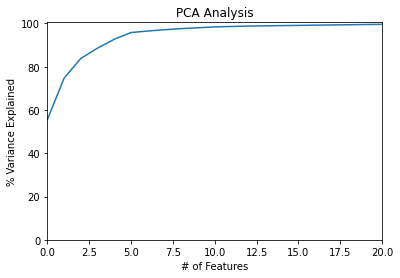

In [24]:
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(0,100.5)
plt.xlim([0, 20])
plt.style.context('seaborn-whitegrid')


plt.plot(var)
plt.show()

## 2.3 Clustering!

In [25]:
new_sound_info['audio_feature_0']=new_sound_info['audio_feature_0']/ (np.std(new_sound_info['audio_feature_0']))
new_sound_info['audio_feature_1']=new_sound_info['audio_feature_1']/ (np.std(new_sound_info['audio_feature_1']))
new_sound_info['audio_feature_2']=new_sound_info['audio_feature_2']/ (np.std(new_sound_info['audio_feature_2']))

  0%|          | 0/8 [00:00<?, ?it/s]

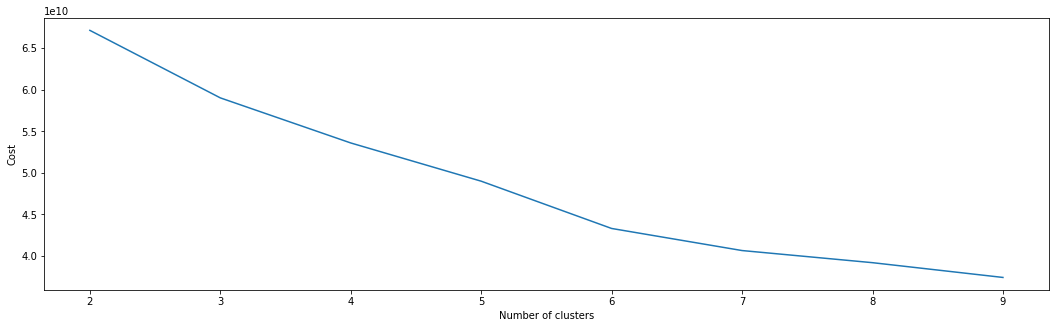

In [27]:
max_K = 10


# initialize output array
cost_array = []

for i in tqdm(range(2,max_K)):
    n_iter, labels, centroids, cost = custom_kmeans(new_sound_info, i)
    cost_array.append(cost)

# plot them
fig, ax = plt.subplots(figsize = (18,5))

ax.plot(range(2,max_K), cost_array)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Cost')
ax.set_xticks(range(2,max_K))


plt.show()

Based on the elbow method, we chose K = 5. We implemented the silhouette method but it is not displayed here ( run_elbow_silhouette() in clustering.py ).

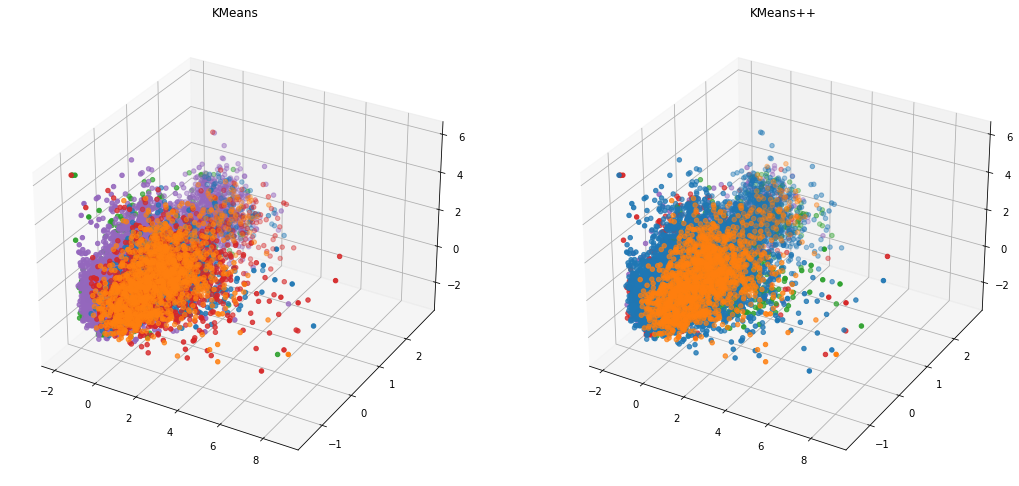

In [29]:
K = 5

custom_n_iter, custom_labels, custom_centroids, custom_cost = custom_kmeans(new_sound_info, K)
plus_plus_n_iter, plus_plus_labels, plus_plus_centroids, plus_plus_cost = kmeans_plus_plus(new_sound_info, K)

features_3dplot_comparison(new_sound_info, K, custom_labels, plus_plus_labels)

The two are visually very similar. We would like to check how many labels the two methofd have in common but we do not have time.

Scatter matrix of the data

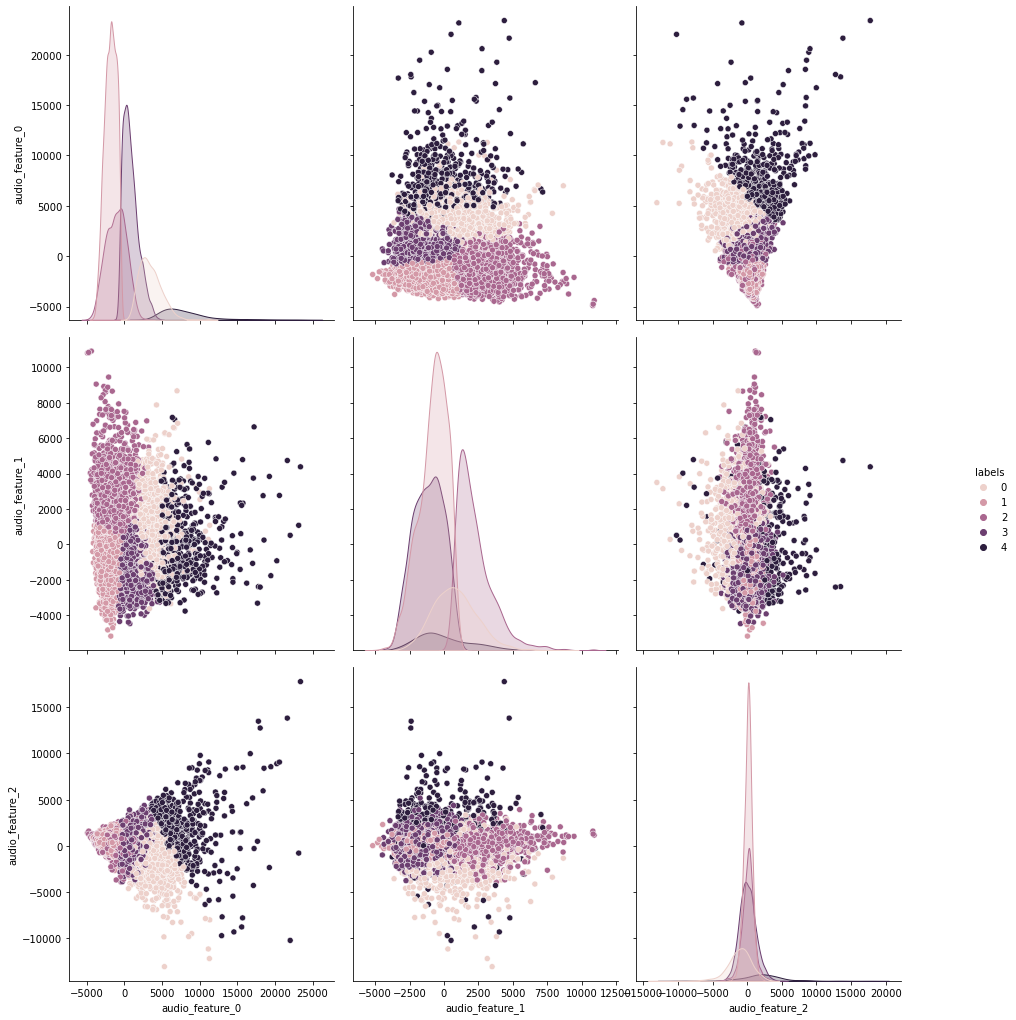

In [236]:
new_sound_info['labels'] = custom_labels
sns.pairplot(new_sound_info, hue = 'labels').fig.set_size_inches(15,15)
plt.show()

## 2.4 Analysing your results!

In [ ]:
temp = pd.merge(echonest, features, on = 'track_id')
df= pd.merge(temp, tracks, on = 'track_id')

In [ ]:
df_new=df[['audio_features_danceability','audio_features_energy','metadata_artist_location','track_language_code','track_duration','audio_features_acousticness']]

In [ ]:
df_new

In [ ]:
#dealing with Nan
df_new['track_language_code'] = df_new['track_language_code'].fillna('unknown')
df_new.fillna(df_new.mean())

In [ ]:
def mmsm(column):
    minim=min(column)
    st=np.std(column)
    media=np.mean(column)
    massimo=max(column)
    return(minim,media,st,massimo)

In [ ]:
minim,media,st,massimo=mmsm(df_new['audio_features_danceability'] )
df_new['audio_features_danceability'] = df['audio_features_danceability'].apply(lambda x: 0 if x<(media-st) else 0.25 if media-st<x<media else 0.5 if media<x<=(media+st) else 1); 

In [ ]:
minim,media,st,massimo=mmsm(df_new['audio_features_energy'] )
df_new['audio_features_energy'] = df['audio_features_energy'].apply(lambda x: 0 if x<(media-st) else 0.25 if media-st<x<media else 0.5 if media<x<=(media+st) else 1); 

In [ ]:
minim,media,st,massimo=mmsm(df_new['track_duration'] )
df_new['track_duration'] = df['track_duration'].apply(lambda x: minim if x<(media-st) else 0.25 if media-st<x<media else 0.5 if media<x<=(media+st) else massimo);

In [ ]:
minim,media,st,massimo=mmsm(df_new['audio_features_acousticness'] )
df_new['audio_features_acousticness'] = df['audio_features_acousticness'].apply(lambda x: 0 if x<(media-st) else 0.25 if media-st<x<media else 0.5 if media<x<=(media+st) else 1); 

In [ ]:
df_new

## 3. Algorithmic questions

You are given a list of integers, *A*, and another integer *s*. Write an algorithm that outputs all the pairs in *A* that equal *x*.

For example, if
```
A = [7, -2, 8, 2, 6, 4, -7, 2, 1, 3, -3] and s = 4
```
the algorithm should output: `(7, -3), (-2, 6), (2, 2), (3, 1)`.

In writing the algorithm, we had to choose whether to display or to discard duplicated output pairs.

We started by writing a simple $O(n^2)$ algorithm that does not remove eventual duplicated pairs.

```
    fixed_sum_with_duplicates(A,s):
    
        results = []
        
        for i in range(len(A)):
            j=i+1
            while j<len(A):
                if A[i]+A[j]==s:
                    results.append((A[i],A[j]))
                j+=1
    
    return(results)
    
```

And then we proceed exploring some ideas about an algorithm that does remove them.

If one expects a small number of output pairs, it may be convenient to actually perform the duplicates drop on the output of the previous algorithm. We then proceeded to write an algorithm that does not output duplicated pairs at all.

If we denote with $k$ the number of elements of A that are bigger than $\frac{s}{2}$, then the following algorithm has a computational complexity of $O(k(n-k)$ (where $n$ is the size of the input array). If one knows something about the distribution of the integers in the input array, then it may be convenient to use it, but in the average case $k\approx \frac{n}{2}$ and the complexity is, again, $O(n^2)$.

```
    fixed_sum_without_duplicates(A,s):
    
        results = []
        
        split_value = s/2    # split_value can be a float in case s is odd
        
        # save these two in linked lists to allow for fast element removal
        A_bigger = [elements of A strictly bigger than split_value]
        A_smaller = [elements of A strictly smaller than split_value]
        
        
        n = len(A)
        n_b = len(A_bigger)
        n_s = len(A_smaller)
        
        
        
        if n-n_b-n_s >= 2:   # this can happen only if s is even
            results.append( (s/2, s/2) )
        
    
        for element in A_bigger:
            found = False
            target = s - element
            for value in A_smaller:
                if target == value:
                    found = True
                    remove(value)    # remove value from A_smaller
            if found:
                results.append( (element, target) )
    
    
    return(results)
    
```

We then realized that the problem has a very natural $O(n)$ solution when the input array is sorted. Using then a sorting algorithm to sort A like QuickSort we can achieve an average overall complexity of $O(n(\log(n)+1))=O(n\log(n))$ (or even lower if one has some clues about the number of digits of the biggest element of the input array and wants to use RadixSort).

```
    fixed_sum_sorted(A,s):
        
        # here we assume that A is sorted
    
        results = []
        
        # here we check if a couple that sums to s actually exists
        if s > 0 and 2*A[-1] < s:
            return(results)
        elif s < 0 and 2*A[0] > s:
            return(results)
        
        
        split_value = s/2
        
        # we use two indices to navigate the array:
        i = 0               # used to navigate the array from left to right
        j = len(A) - 1      # used to navigate the array from right to left
        
        
        while ( j>i ):
            
            target = s - A[i]   # value such that A[i]+target = s
            
            if ( A[j] > target ):
                j = decrement( A, j, target)  # decrement j until A[j] <= target
            
            if ( A[j] == target ):
                results.append( (A[i], A[j]) )
                j = decrement( A, j, target - 1)   # decrement j until A[j] <= target-1
            
            if ( A[j] < target ):
                target = s - A[j]
                i = increment( A, i, target)    # increment i until A[i] >= target
        
    
    return(results)
    
    
    # Here we define the two decrement and increment functions
    
    decrement ( A, j, target):
    
        # decrement j until A[j] <= target
        
        while ( A[j] > target ):
            j -= 1
        
        return (j)
    
    
    increment ( A, i, target):
    
        # increment i until A[i] >= target
        
        while ( A[i] < target ):
            i += 1
        
        return (i)
    
```

Finally, thinking about a possible Python implementation, we came up with an algorithm that uses python sets. Since Python sets are implemented with hash tables, we have the [following **average** complexity for some operations](https://wiki.python.org/moin/TimeComplexity):
* we transform an array in a set in $O(n)$
* we can search if an element is in a set in $O(1)$
* we can add an element in a set in $O(1)$

So, using sets, we can achieve an average $O(n)$ complexity. The algorithm works like this: we look at each element of the set and, if we have never seen its complement (with respect to $s$), we save it in a set, otherwise we have found a proper pair.

In [10]:
def linear_algorithm(array,s):
    
    results = []
    
    # edge case
    if s%2 == 0:
        if array.count(s//2)>1:
            results.append((s//2,s//2))
    
    new_set=set(array)
    other_set=set()
    
    for elem in new_set:
        if (s-elem) not in other_set:
            other_set.add(elem)
        else:
            results.append((s-elem,elem))
    
    return(results)

In [12]:
A=[1,2,1,2,1,2,3,-1,-1,-3,8]
s=4

result = linear_algorithm(A,s)
print(result)

[(2, 2), (1, 3)]


In [13]:
A=[7, -2, 8, 2, 6, 4, -7, 2, 1, 3, -3]
s=4

result = linear_algorithm(A,s)
print(result)

[(2, 2), (1, 3), (7, -3), (6, -2)]
